### data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

R_flat = pd.read_csv("result/result_R.csv")

I_len = R_flat["generator"].nunique()
T_len = R_flat["time"].nunique() 
S_len = R_flat["scenario"].nunique()

R = R_flat.pivot_table(
    values="value",
    index="generator",
    columns=["time", "scenario"]
).to_numpy()
R = R.reshape(I_len, T_len, S_len)

I, T, S = R.shape

price_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_price.csv"
)
price_q["Time"] = pd.to_datetime(price_q["Time"], format="%Y-%m-%d %H:%M")

price_q["Hour"] = price_q["Time"].dt.floor("h")
price_h = price_q.groupby("Hour").mean(numeric_only=True)

price = price_h.iloc[: S * T]

P_DA = np.array(
    [sum(price["Price"].iloc[t + s * T] for s in range(S)) / S * 1.2 for t in range(T)]
)
P_RT = np.array([[price["Price"].iloc[t + s * T] for s in range(S)] for t in range(T)])
P_PN = np.array(
    [sum(price["Price"].iloc[t + s * T] for s in range(S)) / S * 2 for t in range(T)]
)

only_profit = pd.read_csv('result/result_only_profit.csv').values

### settlement model

In [2]:
set = gp.Model("Settlement")
# set.setParam('TimeLimit', 3600)
# set.setParam("PoolSolutions", 15)
# set.setParam("PoolSearchMode", 2)
# set.setParam("PoolGap", 0.05)
# set.setParam("MIPGap", 1e-3)
set.setParam("Heuristics", 0.2)


x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
y_plus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
y_minus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
M_y = max(R[i, t, s] for i in range(I) for t in range(T) for s in range(S))
z_y = set.addVars(I, T, S, vtype=GRB.BINARY, name="z_y")

d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
d_given = set.addVars(I, S, vtype=GRB.CONTINUOUS, name="d_given")
d_received = set.addVars(I, S, vtype=GRB.CONTINUOUS, name="d_received")
d_max_H = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="d_max_H")
d_plus = set.addVars(I, S, vtype=GRB.CONTINUOUS, lb=0, name="d_plus")
d_minus = set.addVars(I, S, vtype=GRB.CONTINUOUS, lb=0, name="d_minus")

e_plus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_plus")
e_minus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_minus")
M_e = max(sum(R[i, t, s] for i in range(I)) for t in range(T) for s in range(S))
z_e = set.addVars(T, S, vtype=GRB.BINARY, name="z_e")

profit_increase = set.addVars(I, vtype=GRB.CONTINUOUS, lb=0, name="profit_increase")

set.update()

# obj. func.
obj = (
    gp.quicksum(P_DA[t] * x[i, t] for i in range(I) for t in range(T))
    + gp.quicksum(
        1 / S * (P_RT[t, s] * e_plus[i, t, s] - P_PN[t] * e_minus[i, t, s])
        for i in range(I)
        for t in range(T)
        for s in range(S)
    )
    - gp.quicksum(
        (d_plus[i, s] + d_minus[i, s]) for i in range(I) for s in range(S)
    )
)

set.setObjective(obj, GRB.MAXIMIZE)

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter Heuristics to value 0.2


In [3]:
# x로 y+, y- 결정 지어주기
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(R[i, t, s] - x[i, t] == y_plus[i, t, s] - y_minus[i, t, s])

# y+, y- 둘 중 하나는 0이어야함
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(y_plus[i, t, s] <= M_y * z_y[i, t, s])
            set.addConstr(y_minus[i, t, s] <= M_y * (1 - z_y[i, t, s]))

# rt 조건
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(y_plus[i, t, s] <= R[i, t, s])

# sum e+, sum e- 결정 지어주기
for t in range(T):
    for s in range(S):
        set.addConstr(
            gp.quicksum(R[i, t, s] for i in range(I))
            - gp.quicksum(x[i, t] for i in range(I))
            == gp.quicksum(e_plus[i, t, s] for i in range(I))
            - gp.quicksum(e_minus[i, t, s] for i in range(I))
        )

# sum e+, sum e- 둘 중 하나는 0이어야 함
for t in range(T):
    for s in range(S):
        set.addConstr(gp.quicksum(e_plus[i, t, s] for i in range(I)) <= M_e * z_e[t, s])
        set.addConstr(
            gp.quicksum(e_minus[i, t, s] for i in range(I)) <= M_e * (1 - z_e[t, s])
        )

# e+, e- 정의
for i in range(I):
    for t in range(T):
        for s in range(S):
            # e_plus: 초과량에서 준 양을 뺀 것
            set.addConstr(
                e_plus[i, t, s]
                == y_plus[i, t, s]
                - gp.quicksum(d[i, j, t, s] for j in range(I) if j != i)
            )
            # e_minus: 부족량에서 받은 양을 뺀 것
            set.addConstr(
                e_minus[i, t, s]
                == y_minus[i, t, s]
                - gp.quicksum(d[j, i, t, s] for j in range(I) if j != i)
            )

# sum e+ <= sum R
for t in range(T):
    for s in range(S):
        set.addConstr(
            gp.quicksum(e_plus[i, t, s] for i in range(I))
            <= gp.quicksum(R[i, t, s] for i in range(I))
        )

# 전력 이동 제한
for i in range(I):
    for t in range(T):
        for s in range(S):
            # 본인이 주는 양은 자신의 y+을 넘을 수 없음
            set.addConstr(
                gp.quicksum(d[i, j, t, s] for j in range(I) if j != i)
                <= y_plus[i, t, s]
            )
            # 본인이 받는 양은 자신의 y-을 넘을 수 없음
            set.addConstr(
                gp.quicksum(d[j, i, t, s] for j in range(I) if j != i)
                <= y_minus[i, t, s]
            )

# 자기 자신과의 거래 방지
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(d[i, i, t, s] == 0)

# d_given, d_received 정의
for i in range(I):
    for s in range(S):
        set.addConstr(
            d_given[i, s]
            == gp.quicksum(d[i, j, t, s] for j in range(I) if j != i for t in range(T))
        )
        set.addConstr(
            d_received[i, s]
            == gp.quicksum(d[j, i, t, s] for j in range(I) if j != i for t in range(T))
        )

# d+, d- 정의
for i in range(I):
    for s in range(S):
        set.addConstr(
            d_given[i,s] - d_received[i,s] == d_minus[i,s] - d_plus[i,s]
        )

# # d+, d- 정의
# for i in range(I):
#     for s in range(S):
#         set.addConstr(
#             d_given[i,s] - d_received[i,s] == d_minus[i,s] - d_plus[i,s]
#         )

# # 수익증가율 정의
# for i in range(I):
#     set.addConstr(profit_increase[i] == (
#         gp.quicksum(
#             P_DA[t] * x[i, t]
#             + 1 / S * gp.quicksum(P_RT[t, s] * e_plus[i, t, s] - P_PN[t] * e_minus[i, t, s] for s in range(S))
#             for t in range(T)
#         ) - only_profit[i].item()
#     ) / only_profit[i].item())

# # 수익증가율이 사람마다 같아야함
# for i in range(I):
#     set.addConstr(
#         profit_increase[i] == gp.quicksum(profit_increase[j] for j in range(I)) / I
#     )

In [4]:
set.optimize()

if set.status == GRB.OPTIMAL:
    x_vals = np.array([[x[i, t].x for t in range(T)] for i in range(I)])
    y_plus_vals = np.array(
        [[[y_plus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    y_minus_vals = np.array(
        [[[y_minus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    d_vals = np.array(
        [
            [[[d[i, j, t, s].x for s in range(S)] for t in range(T)] for j in range(I)]
            for i in range(I)
        ]
    )
    d_given_vals = np.array([d_given[i, s].x for i in range(I) for s in range(S)])
    d_received_vals = np.array([d_received[i, s].x for i in range(I) for s in range(S)])
    e_plus_vals = np.array(
        [[[e_plus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    e_minus_vals = np.array(
        [[[e_minus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    z_y_vals = np.array(
        [[[z_y[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    z_e_vals = np.array(
        [[z_e[t, s].x for s in range(S)] for t in range(T)]
    )
    profit_increase_vals = np.array(
        [[profit_increase[i].x for i in range(I)]]
    )
    print("\n- - - - - - - - - - - - - - - - - - - - - - - -")
    print("Optimal solution found!")
    print(set.objVal)
else:
    print("\nNo optimal solution found.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
Heuristics  0.2

Optimize a model with 45720 rows, 74010 columns and 362160 nonzeros
Model fingerprint: 0x883d6633
Variable types: 68730 continuous, 5280 integer (5280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [4e-04, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 9e+01]
Presolve removed 39247 rows and 57238 columns
Presolve time: 0.13s
Presolved: 6473 rows, 16772 columns, 65937 nonzeros
Variable types: 15363 continuous, 1409 integer (1409 binary)

Root relaxation: objective 1.186137e+04, 19613 iterations, 1.24 seconds (1.78 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 11861.3669    0  230  

In [5]:
if set.SolCount > 0:
    print(f"Best objective found: {set.ObjVal}")
    for v in set.getVars():
        print(f"{v.VarName} = {v.X}")
else:
    print("No feasible solution found.")

Best objective found: 11655.33284506035
x[0,0] = 0.0
x[0,1] = 0.0
x[0,2] = 0.0
x[0,3] = 0.0
x[0,4] = 0.0
x[0,5] = 0.0
x[0,6] = 0.0
x[0,7] = 0.0
x[0,8] = 0.0
x[0,9] = 0.1738820077880944
x[0,10] = 0.6941947593647306
x[0,11] = 0.0
x[0,12] = 4.618416765247872
x[0,13] = 4.184147492349971
x[0,14] = 18.7753858121748
x[0,15] = 0.5865778630909718
x[0,16] = 0.0
x[0,17] = 0.0
x[0,18] = 0.0
x[0,19] = 0.0
x[0,20] = 0.0
x[0,21] = 0.0
x[0,22] = 0.0
x[0,23] = 0.0
x[1,0] = 0.0
x[1,1] = 0.0
x[1,2] = 0.0
x[1,3] = 0.0
x[1,4] = 0.0
x[1,5] = 0.0
x[1,6] = 0.0
x[1,7] = 0.0
x[1,8] = 0.0
x[1,9] = 2.5985057373291536
x[1,10] = 0.0
x[1,11] = 0.0
x[1,12] = 13.475557788126967
x[1,13] = 0.0
x[1,14] = 0.21284557344622407
x[1,15] = 0.0
x[1,16] = 0.0
x[1,17] = 0.0
x[1,18] = 0.0
x[1,19] = 0.0
x[1,20] = 0.0
x[1,21] = 0.0
x[1,22] = 0.0
x[1,23] = 0.0
x[2,0] = 0.0
x[2,1] = 0.0
x[2,2] = 0.0
x[2,3] = 0.0
x[2,4] = 0.0
x[2,5] = 0.0
x[2,6] = 0.0
x[2,7] = 0.0
x[2,8] = 0.0
x[2,9] = 0.0
x[2,10] = 0.0
x[2,11] = 0.0
x[2,12] = 0.0
x[2,

### solution pool

In [6]:
print(f"Status: {set.status}")
if set.status == GRB.OPTIMAL:
    print("모델이 Optimal입니다")

    # Solution pool 확인
    print("\nSolution Pool 정보:")
    print(f"찾은 해의 개수: {set.SolCount}")

    # Best solution의 objective value
    best_obj = set.ObjVal
    print(f"\nBest Solution의 Objective Value: {best_obj}")

    # 각 솔루션의 목적함수 값 출력 및 best solution 여부 확인
    solutions = []
    for i in range(set.SolCount):
        set.params.SolutionNumber = i
        solutions.append((i, set.PoolObjVal))
        print(f"\nSolution {i}:")
        print(f"Objective value: {set.PoolObjVal}")
        print(f"Objective bound: {set.PoolObjBound}")
    # Solution pool 파라미터 확인
    print("\nSolution Pool 파라미터:")
    print(f"PoolSolutions: {set.Params.PoolSolutions}")
    print(f"PoolSearchMode: {set.Params.PoolSearchMode}")
    print(f"PoolGap: {set.Params.PoolGap}")
elif set.status == GRB.UNBOUNDED:
    print("모델이 Unbounded입니다")
    # Unbounded ray 확인
    set.computeIIS()
    set.write("model.ilp")
elif set.status == GRB.INFEASIBLE:
    print("모델이 Infeasible입니다")
    # IIS 계산
    set.computeIIS()
    set.write("model.ilp")
elif set.status == GRB.INF_OR_UNBD:
    print("모델이 Infeasible 또는 Unbounded입니다")
    # Presolve를 끄고 다시 시도
    set.setParam("Presolve", 0)
    set.optimize()
elif set.status == GRB.TIME_LIMIT:
    print("시간 제한에 도달했습니다")
    if set.SolCount > 0:
        print(f"현재까지의 최선해: {set.objVal}")
        print(f"Optimality Gap: {set.MIPGap}")

Status: 11


In [7]:
# 솔루션 풀에서 해 확인
solution_count = set.SolCount
print(f"총 {solution_count}개의 해가 저장되었습니다.")

for i in range(solution_count):
    set.setParam(GRB.Param.SolutionNumber, i)
    print(f"\n해 {i+1}: 목적 함수 값 = {set.PoolObjVal}")
    # x 변수 값 출력
    for t in range(14, 15):
        for i in range(1, 5):
            print(f"x[{i},{t}] = {x[i, t].Xn}")

총 10개의 해가 저장되었습니다.

해 1: 목적 함수 값 = 11655.33284506035
x[1,14] = 0.21284557344622407
x[2,14] = 0.7904931688978283
x[3,14] = 0.5715646362047233
x[4,14] = 0.3956386037380821

해 2: 목적 함수 값 = 11655.275417039726
x[1,14] = 0.3162668997586895
x[2,14] = 0.7843521938958311
x[3,14] = 0.7162222022048835
x[4,14] = 0.24057682636287353

해 3: 목적 함수 값 = 11655.274069653315
x[1,14] = 0.31183081083246744
x[2,14] = 0.7843521938958276
x[3,14] = 0.5052312627080457
x[4,14] = 0.20380910396735263

해 4: 목적 함수 값 = 11655.263987421984
x[1,14] = 0.30037334967951956
x[2,14] = 0.7843521938958321
x[3,14] = 0.5715646362046982
x[4,14] = 0.2242982298064917

해 5: 목적 함수 값 = 11655.260134270735
x[1,14] = 0.2935333836037697
x[2,14] = 0.7843521938958311
x[3,14] = 0.7737122874113336
x[4,14] = 0.15018007342818773

해 6: 목적 함수 값 = 11655.23844491588
x[1,14] = 0.18104212633658
x[2,14] = 0.7911921599714953
x[3,14] = 0.5715646362047169
x[4,14] = 0.5847567230787902

해 7: 목적 함수 값 = 11655.22862231095
x[1,14] = 0.1301569966399745
x[2,14] = 

### 결과 분석

#### 수익 분석

In [8]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for i in range(I):
    for t in range(T):
        total_da_profit_obj += P_DA[t] * x[i, t].x

# Real-time 수익 비교
total_rt_profit_obj = 0
for i in range(I):
    for t in range(T):
        for s in range(S):
            rt_profit_obj = P_RT[t, s] * e_plus[i, t, s].x
            total_rt_profit_obj += 1 / S * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for i in range(I):
    for t in range(T):
        for s in range(S):
            penalty_cost_obj = P_PN[t] * e_minus[i, t, s].x
            total_penalty_cost_obj += 1 / S * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = (
    total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj
)

# 결과 출력
print(f"DA: {total_da_profit_obj:.2f}")
print(f"RT: {total_rt_profit_obj:.2f}")
print(f"Penalty: {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")

DA: 8254.19
RT: 3895.15
Penalty: 301.53
목적 함수 기반 총 이익 (_obj): 11847.81


#### daily commitment

In [9]:
for t in range(T):
    avg_e_plus = sum(e_plus[i, t, s].x for i in range(I) for s in range(S)) / S
    avg_e_minus = sum(e_minus[i, t, s].x for i in range(I) for s in range(S)) / S
    print(
        f"[시간 {t}] x: {sum(x[i, t].x for i in range(I)):.3f}, e+: {avg_e_plus:.3f}, e-: {avg_e_minus:.3f}"
    )

total_x = sum(x[i, t].x for i in range(I) for t in range(T))
print(f"총 하루 commitment: {total_x:.3f}")

[시간 0] x: 0.000, e+: 0.000, e-: 0.000
[시간 1] x: 0.000, e+: 0.000, e-: 0.000
[시간 2] x: 0.000, e+: 0.000, e-: 0.000
[시간 3] x: 0.000, e+: 0.000, e-: 0.000
[시간 4] x: 0.000, e+: 0.000, e-: 0.000
[시간 5] x: 0.000, e+: 0.000, e-: 0.000
[시간 6] x: 0.000, e+: 0.000, e-: 0.000
[시간 7] x: 0.000, e+: 0.000, e-: 0.000
[시간 8] x: 1.012, e+: 1.108, e-: 0.124
[시간 9] x: 8.261, e+: 4.607, e-: 0.400
[시간 10] x: 22.352, e+: 10.231, e-: 0.000
[시간 11] x: 30.981, e+: 14.335, e-: 1.591
[시간 12] x: 34.485, e+: 20.907, e-: 0.134
[시간 13] x: 39.040, e+: 18.203, e-: 0.250
[시간 14] x: 29.755, e+: 20.297, e-: 0.054
[시간 15] x: 25.211, e+: 10.190, e-: 0.765
[시간 16] x: 11.532, e+: 7.772, e-: 1.123
[시간 17] x: 2.138, e+: 2.851, e-: 0.234
[시간 18] x: 0.061, e+: 0.455, e-: 0.021
[시간 19] x: 0.000, e+: 0.000, e-: 0.000
[시간 20] x: 0.000, e+: 0.000, e-: 0.000
[시간 21] x: 0.000, e+: 0.000, e-: 0.000
[시간 22] x: 0.000, e+: 0.000, e-: 0.000
[시간 23] x: 0.000, e+: 0.000, e-: 0.000
총 하루 commitment: 204.828


### exchange process

In [10]:
for t in range(12,14):
    x_sum = sum(x[i, t].x for i in range(I))

    for s in range(S):
        y_plus_sum = sum(y_plus[i, t, s].x for i in range(I))
        y_minus_sum = sum(y_minus[i, t, s].x for i in range(I))

        e_plus_sum = sum(e_plus[i, t, s].x for i in range(I))
        e_minus_sum = sum(e_minus[i, t, s].x for i in range(I))

        print(f"[t={t} s={s}]")

        print(f"x 합계: {x_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {x[i,t].x:.2f}", end=" ")
        print(")")

        print(f"y+ 합계: {y_plus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {y_plus[i,t,s].x:.2f}", end=" ")
        print(")")

        print(f"y- 합계: {y_minus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {y_minus[i,t,s].x:.2f}", end=" ")
        print(")")

        print(f"e+ 합계: {e_plus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {e_plus[i,t,s].x:.2f}", end=" ")
        print(")")

        print(f"e- 합계: {e_minus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {e_minus[i,t,s].x:.2f}", end=" ")
        print(")")

        print("거래 내역:")
        for i in range(I):
            for j in range(I):
                if d[i, j, t, s].x > 1e-6:
                    print(
                        f"발전기 {i}가 발전기 {j}에게 {d[i,j,t,s].x:.2f} 전력을 줌"
                    )
        print()

[t=12 s=0]
x 합계: 34.49 ([0] 4.62 [1] 13.48 [2] 0.00 [3] 4.42 [4] 0.73 [5] 4.73 [6] 0.00 [7] 0.00 [8] 0.00 [9] 6.52 )
y+ 합계: 41.29 ([0] 6.98 [1] 0.00 [2] 7.81 [3] 0.00 [4] 9.05 [5] 0.00 [6] 12.14 [7] 0.85 [8] 4.47 [9] 0.00 )
y- 합계: 22.07 ([0] 0.00 [1] 13.48 [2] 0.00 [3] 4.42 [4] 0.00 [5] 0.09 [6] 0.00 [7] 0.00 [8] 0.00 [9] 4.08 )
e+ 합계: 19.22 ([0] 0.14 [1] 0.00 [2] 5.79 [3] 0.00 [4] 7.69 [5] 0.00 [6] 4.76 [7] 0.85 [8] 0.00 [9] 0.00 )
e- 합계: 0.00 ([0] 0.00 [1] 0.00 [2] 0.00 [3] 0.00 [4] 0.00 [5] 0.00 [6] 0.00 [7] 0.00 [8] 0.00 [9] 0.00 )
거래 내역:
발전기 0가 발전기 1에게 6.09 전력을 줌
발전기 0가 발전기 9에게 0.74 전력을 줌
발전기 2가 발전기 5에게 0.09 전력을 줌
발전기 2가 발전기 9에게 1.93 전력을 줌
발전기 4가 발전기 3에게 1.37 전력을 줌
발전기 6가 발전기 1에게 7.38 전력을 줌
발전기 8가 발전기 3에게 3.05 전력을 줌
발전기 8가 발전기 9에게 1.41 전력을 줌

[t=12 s=1]
x 합계: 34.49 ([0] 4.62 [1] 13.48 [2] 0.00 [3] 4.42 [4] 0.73 [5] 4.73 [6] 0.00 [7] 0.00 [8] 0.00 [9] 6.52 )
y+ 합계: 36.69 ([0] 0.00 [1] 0.00 [2] 12.76 [3] 0.00 [4] 5.89 [5] 0.00 [6] 8.88 [7] 8.84 [8] 0.00 [9] 0.33 )
y- 합계: 12.88 ([0] 

In [11]:
d_given = np.zeros(I)
d_received = np.zeros(I)

for i in range(I):
    d_given[i] = sum(
        sum(d[i, j, t, s].x for j in range(I) if j != i for t in range(T)) / S
        for s in range(S)
    )
    d_received[i] = sum(
        sum(d[j, i, t, s].x for j in range(I) if j != i for t in range(T)) / S
        for s in range(S)
    )

set_d = pd.DataFrame({"set_d_given": d_given, "set_d_received": d_received})
set_d.to_csv("result/result_set5.1_d.csv", index=False)

### 정산

In [12]:
total_der_profit = 0
der_profit = {}
for i in range(I):
    der_profit[i] = sum(P_DA[t] * x[i,t].x + sum(1/S * (P_RT[t,s] * e_plus[i,t,s].x - P_PN[t] * e_minus[i,t,s].x) for s in range(S)) for t in range(T))
    total_der_profit += der_profit[i]

print(f"\n모든 der의 profit 합계: {total_der_profit:.2f}")

print("\n최종 profit:")
for i in range(I):
    print(f"[{i}] {der_profit[i]:.2f} ({(der_profit[i]-only_profit[i].item())/only_profit[i].item() * 100:.2f}%)")


모든 der의 profit 합계: 11847.81

최종 profit:
[0] 1535.59 (27.49%)
[1] 935.00 (7.16%)
[2] 1474.08 (19.12%)
[3] 1335.12 (18.31%)
[4] 867.45 (19.77%)
[5] 972.56 (0.94%)
[6] 1739.62 (0.40%)
[7] 1217.17 (10.76%)
[8] 738.76 (-3.92%)
[9] 1032.47 (10.94%)


Surplus 분배 결과:
[0]: 96.35
[1]: 100.34
[2]: 98.11
[3]: 96.31
[4]: 96.12
[5]: 105.17
[6]: 99.38
[7]: 99.62
[8]: 101.06
[9]: 100.78

최종 Profit:
[0] 1300.87 (8.00%)
[1] 972.89 (11.50%)
[2] 1335.61 (7.93%)
[3] 1224.82 (8.53%)
[4] 820.36 (13.27%)
[5] 1068.68 (10.92%)
[6] 1832.09 (5.74%)
[7] 1198.55 (9.07%)
[8] 870.00 (13.14%)
[9] 1031.46 (10.83%)


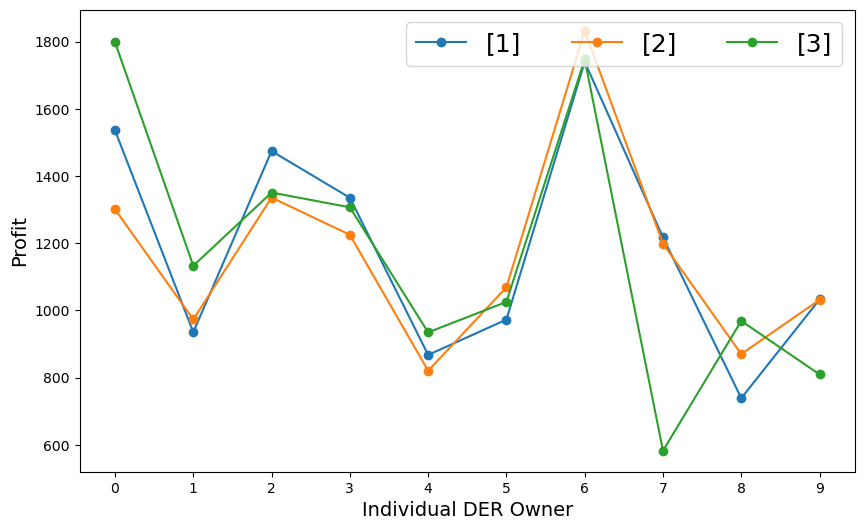

In [16]:
only_value = pd.read_csv('result/result_only_obj.csv').values
only_profit = pd.read_csv('result/result_only_profit.csv').values
surplus = set.objVal - only_value[0] #

I, T, S = R.shape

R_proportion = R / R.sum(axis=1, keepdims=True) 
R_proportion = np.nan_to_num(R_proportion) 

R_proportion_P = np.multiply(R_proportion, P_DA[:, np.newaxis])

R_weighted = R_proportion_P.sum(axis=(1, 2)) 

R_weighted_normalized = R_weighted / R_weighted.sum() 

surplus_distribution = surplus * R_weighted_normalized  

final_profit = only_profit.flatten() + surplus_distribution

print("Surplus 분배 결과:")
for i, value in enumerate(surplus_distribution):
    print(f"[{i}]: {value:.2f}")

print("\n최종 Profit:")
for i, (profit, only) in enumerate(zip(final_profit, only_profit.flatten())):
    increase_percentage = ((profit - only) / only) * 100
    print(f"[{i}] {profit:.2f} ({increase_percentage:.2f}%)")
d_given = np.array(
    [
        sum(
            sum(
                sum(d[i, j, t, s].x for t in range(T)) for j in range(I)
            ) for s in range(S)
        ) / S  # s의 평균 계산
        for i in range(I)
    ]
)
total_sum = np.sum(d_given)
d_given_ratios = d_given / total_sum if total_sum != 0 else np.zeros_like(d_given)
third = np.zeros(I)
third = set.objVal * d_given_ratios
der_indices = np.arange(I)

fig, ax = plt.subplots(figsize=(10, 6))
der_profit_array = np.array(list(der_profit.values()))
first = der_profit_array

plt.plot(der_indices, first, marker="o", label="[1]")
plt.plot(der_indices, final_profit, marker="o", label="[2]")
plt.plot(der_indices, third, marker="o", label="[3]")

ax.set_xlabel("Individual DER Owner", fontsize=14)
ax.set_ylabel("Profit", fontsize=14)
ax.set_xticks(der_indices)  # DER owner 인덱스 설정
ax.legend(loc="upper right", fontsize=18, ncols=4)

# plt.title(f"Profit Remuneration Approaches", fontsize=14)
# plt.savefig(f"figure/fig_renum.pdf", bbox_inches="tight")
plt.show()


In [31]:
total_only = 0
for i in range(I):
    total_only += only_profit.flatten()[i]
total_der_profit_y = 0
der_profit_y = {}
total_der_profit_e = 0
der_profit_e = {}
total_der_profit_d = 0
der_profit_d = {}

for i in range(I):
    der_profit_y[i] = sum(P_DA[t] * x[i,t].x + sum(1/S * (P_RT[t,s] * y_plus[i,t,s].x - P_PN[t] * y_minus[i,t,s].x) for s in range(S)) for t in range(T))
    total_der_profit_y += der_profit_y[i]
    der_profit_d[i] = sum(sum(1/S * ( - P_RT[t,s] * sum(d[i, j, t, s].x for j in range(I) if j != i) + P_PN[t] * sum(d[j, i, t, s].x for j in range(I) if j != i)) for s in range(S)) for t in range(T))
    total_der_profit_d += der_profit_d[i]
    der_profit_e[i] = sum(P_DA[t] * x[i,t].x + sum(1/S * (P_RT[t,s] * e_plus[i,t,s].x - P_PN[t] * e_minus[i,t,s].x) for s in range(S)) for t in range(T))
    total_der_profit_e += der_profit_e[i]

print(f"\nder_only: {total_only:.2f}")
print(f"\nder_profit_y: {total_der_profit_y:.2f}, der_profit_d: {total_der_profit_d:.2f}")
print(f"\nder_profit_e: {total_der_profit_e:.2f}")

print("\n최종 profit:")
for i in range(I):
    print(f"[{i}] {only_profit.flatten()[i]:.2f} || {der_profit_y[i]:.2f} + {der_profit_d[i]:.2f} = {der_profit_e[i]:.2f}")


der_only: 10662.08

der_profit_y: 7968.76, der_profit_d: 3879.05

der_profit_e: 11847.81

최종 profit:
[0] 1204.52 || 754.16 + 781.44 = 1535.59
[1] 872.55 || 610.30 + 324.70 = 935.00
[2] 1237.50 || 877.38 + 596.70 = 1474.08
[3] 1128.51 || 823.83 + 511.29 = 1335.12
[4] 724.24 || 470.66 + 396.80 = 867.45
[5] 963.51 || 761.81 + 210.75 = 972.56
[6] 1732.71 || 1360.33 + 379.28 = 1739.62
[7] 1098.93 || 1020.77 + 196.40 = 1217.17
[8] 768.93 || 563.54 + 175.22 = 738.76
[9] 930.68 || 725.99 + 306.48 = 1032.47


### 결과 저장

In [13]:
set_profit_value = pd.DataFrame({'set_profit_value': der_profit})
set_profit_value.to_csv('result/result_set5.1_profit.csv', index=False)

set_obj = pd.DataFrame({'set_obj': [set.objVal]})
set_obj.to_csv('result/result_set5.1_obj.csv', index=False)